In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import swifter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm
import torch.nn.functional as F
import torch
from torch.nn.functional import softmax
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [23]:
csv_folder = r"C:\Users\jiali\Documents\Studium\DM-Dataset"
csv_path = os.path.join(csv_folder, "merged_Post_with_votes_comments_and_users.csv")
df = pd.read_csv(csv_path)

C:\Users\jiali\AppData\Local\Temp\ipykernel_33460\4092684005.py:3: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [24]:
df.columns

Index(['PostId', 'posts.PostTypeId', 'posts.AcceptedAnswerId',
       'posts.CreationDate', 'posts.Score', 'posts.ViewCount', 'posts.Body',
       'posts.OwnerUserId', 'posts.LastEditorUserId', 'posts.LastEditDate',
       'posts.LastActivityDate', 'posts.Title', 'posts.Tags',
       'posts.AnswerCount', 'posts.CommentCount', 'posts.ContentLicense',
       'posts.ParentId', 'posts.OwnerDisplayName', 'posts.ClosedDate',
       'posts.LastEditorDisplayName', 'posts.CommunityOwnedDate',
       'posts.FavoriteCount', 'posts.CleanBodyNoMath', 'posts.SentimentScore',
       'posts.SentimentLabel', 'CommentId', 'comments.Score', 'comments.Text',
       'comments.CreationDate', 'UserId', 'comments.UserDisplayName',
       'users.Reputation', 'users.CreationDate', 'users.DisplayName',
       'users.LastAccessDate', 'users.WebsiteUrl', 'users.Location',
       'users.AboutMe', 'users.Views', 'users.UpVotes', 'users.DownVotes',
       'users.AccountId', 'users.Country', 'users.SentimentLabel',
  

In [44]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
filtered_num_cols = [col for col in num_cols if 'Id' not in col]

# 计算包含 posts.Score 的相关性矩阵
corr_full = df[filtered_num_cols].corr()


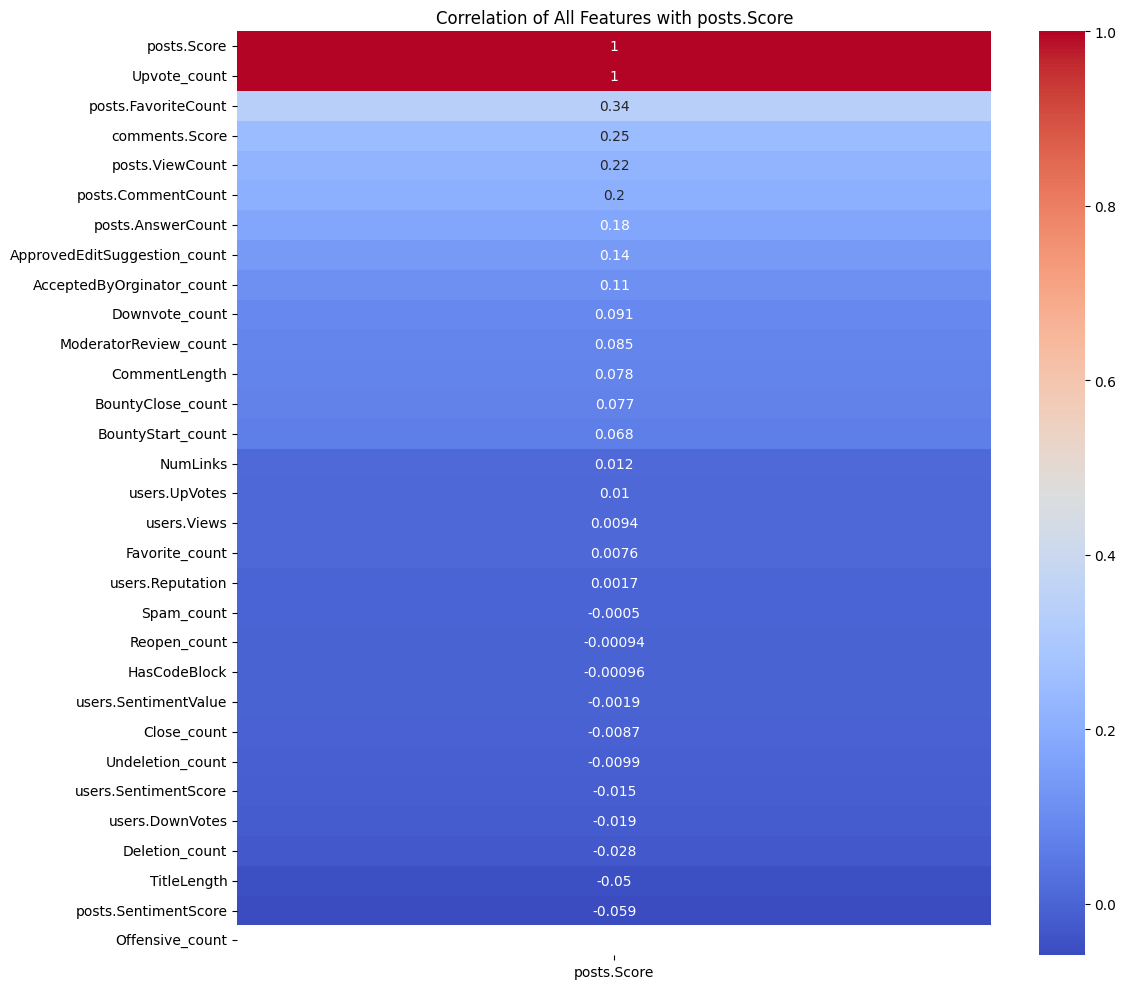

In [45]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_full[['posts.Score']].sort_values(by='posts.Score', ascending=False),
            annot=True, cmap='coolwarm')
plt.title("Correlation of All Features with posts.Score")
plt.tight_layout()
plt.show()

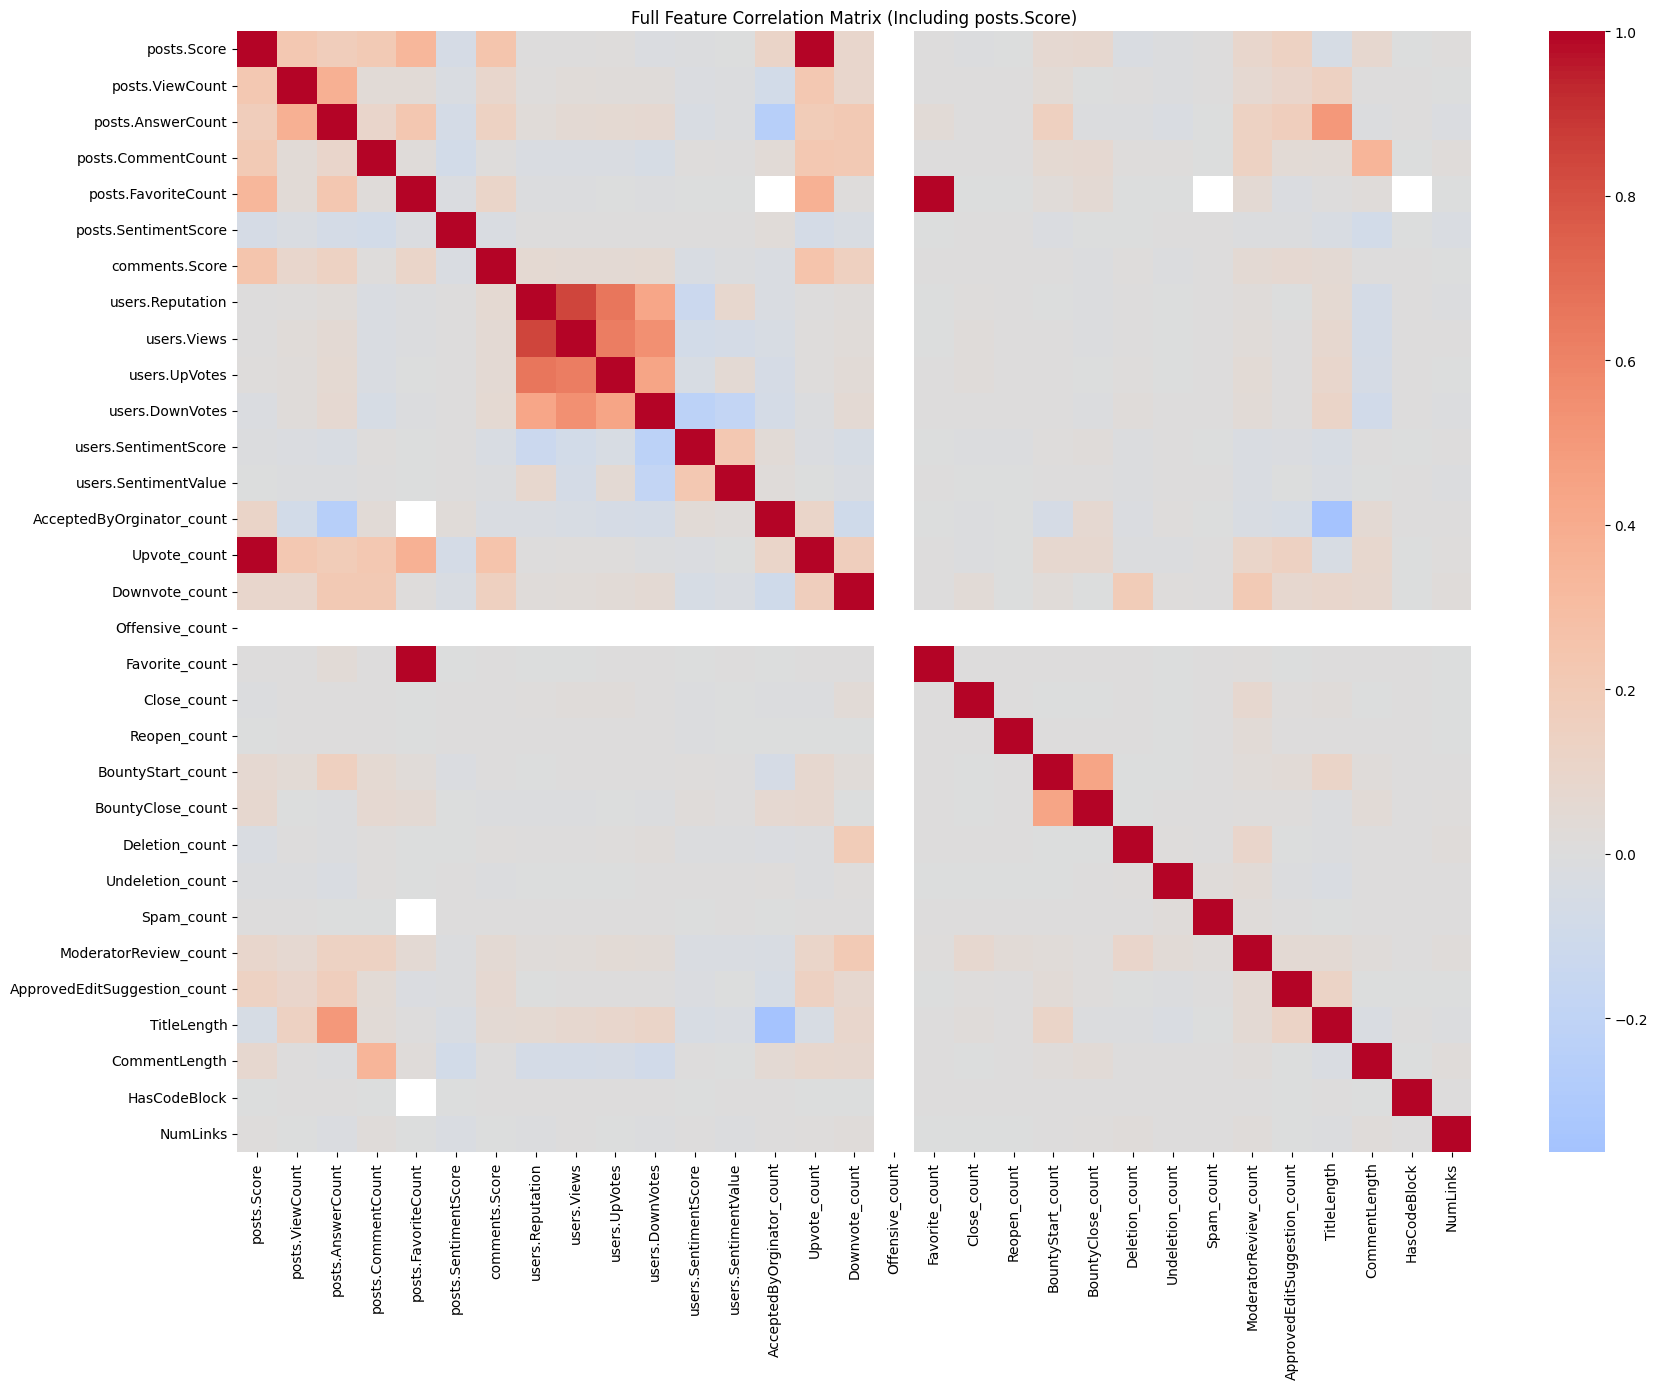

In [46]:
plt.figure(figsize=(18, 14))
sns.heatmap(corr_full, cmap='coolwarm', center=0, annot=False)
plt.title("Full Feature Correlation Matrix (Including posts.Score)")
plt.tight_layout()
plt.show()

In [27]:
filtered_num_cols

['posts.ViewCount',
 'posts.AnswerCount',
 'posts.CommentCount',
 'posts.FavoriteCount',
 'posts.SentimentScore',
 'comments.Score',
 'users.Reputation',
 'users.Views',
 'users.UpVotes',
 'users.DownVotes',
 'users.SentimentScore',
 'users.SentimentValue',
 'AcceptedByOrginator_count',
 'Upvote_count',
 'Downvote_count',
 'Offensive_count',
 'Favorite_count',
 'Close_count',
 'Reopen_count',
 'BountyStart_count',
 'BountyClose_count',
 'Deletion_count',
 'Undeletion_count',
 'Spam_count',
 'ModeratorReview_count',
 'ApprovedEditSuggestion_count']

In [28]:
X_selected = df[filtered_num_cols]

In [29]:
X_selected

,posts.ViewCount,posts.AnswerCount,posts.CommentCount,posts.FavoriteCount,posts.SentimentScore,comments.Score,users.Reputation,users.Views,users.UpVotes,users.DownVotes,...,Favorite_count,Close_count,Reopen_count,BountyStart_count,BountyClose_count,Deletion_count,Undeletion_count,Spam_count,ModeratorReview_count,ApprovedEditSuggestion_count
0,20982.0,6.0,3,NaN,0.6290,10.0,3251.0,708.0,133.0,11.0,...,0,0,0,0,0,0,0,0,0,0
1,20982.0,6.0,3,NaN,0.6290,2.0,152.0,15.0,25.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,20982.0,6.0,3,NaN,0.6290,6.0,201751.0,120311.0,9277.0,9460.0,...,0,0,0,0,0,0,0,0,0,0
3,3946.0,4.0,4,NaN,0.7774,2.0,7362.0,2182.0,151.0,33.0,...,0,0,0,0,0,0,0,0,0,1
4,3946.0,4.0,4,NaN,0.7774,2.0,3251.0,708.0,133.0,11.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339924,66.0,1.0,4,NaN,0.5236,4.0,25924.0,7675.0,539.0,185.0,...,0,0,0,0,0,0,0,0,0,0
1339925,66.0,1.0,4,NaN,0.5236,0.0,3098.0,325.0,171.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1339926,66.0,1.0,4,NaN,0.5236,6.0,25924.0,7675.0,539.0,185.0,...,0,0,0,0,0,0,0,0,0,0
1339927,66.0,1.0,4,NaN,0.5236,0.0,3098.0,325.0,171.0,1.0,...,0,0,0,0,0,0,0,0,0,0


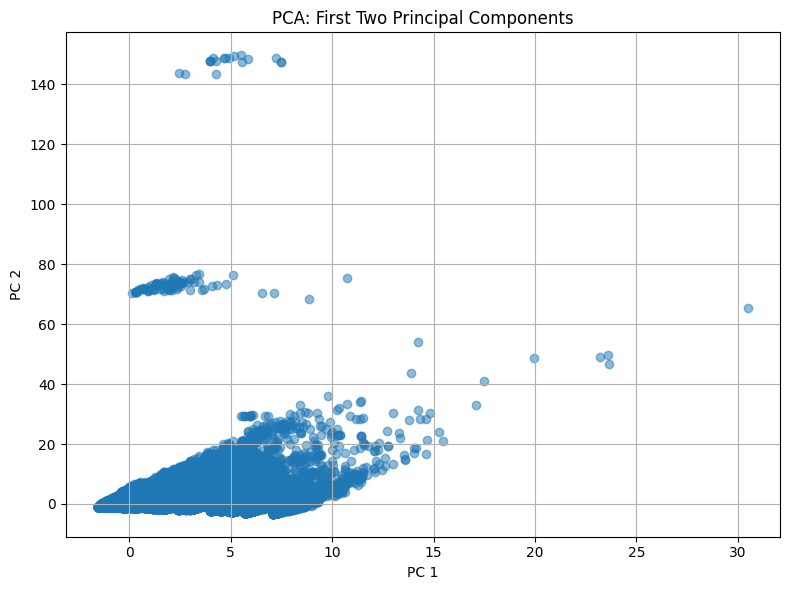

To explain 90% of the variance, use at least 19 components.


In [31]:
X_selected = X_selected[filtered_num_cols].fillna(0)
X_scaled = StandardScaler().fit_transform(X_selected)

# PCA 拟合
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 可视化前 2 个主成分
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA: First Two Principal Components')
plt.grid(True)
plt.tight_layout()
plt.show()

# 输出每个主成分的方差贡献比例
explained_variance_ratio = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained Variance Ratio': pca.explained_variance_ratio_
})

cum_var = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1
print(f"To explain 90% of the variance, use at least {n_components_90} components.")

In [32]:
explained_variance_ratio


,Component,Explained Variance Ratio
0,PC1,1.253151e-01
1,PC2,8.250823e-02
2,PC3,7.900703e-02
3,PC4,5.752905e-02
4,PC5,5.332247e-02
5,PC6,4.926308e-02
6,PC7,4.666935e-02
7,PC8,4.126527e-02
8,PC9,4.058654e-02
9,PC10,4.018970e-02


In [33]:
questions_df = df[df['posts.PostTypeId'] == 1].copy()
answers_df = df[df['posts.PostTypeId'] == 2].copy()


In [47]:
num_cols = questions_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
filtered_num_cols = [col for col in num_cols if 'Id' not in col]

# 计算包含 posts.Score 的相关性矩阵
corr_full = questions_df[filtered_num_cols].corr()

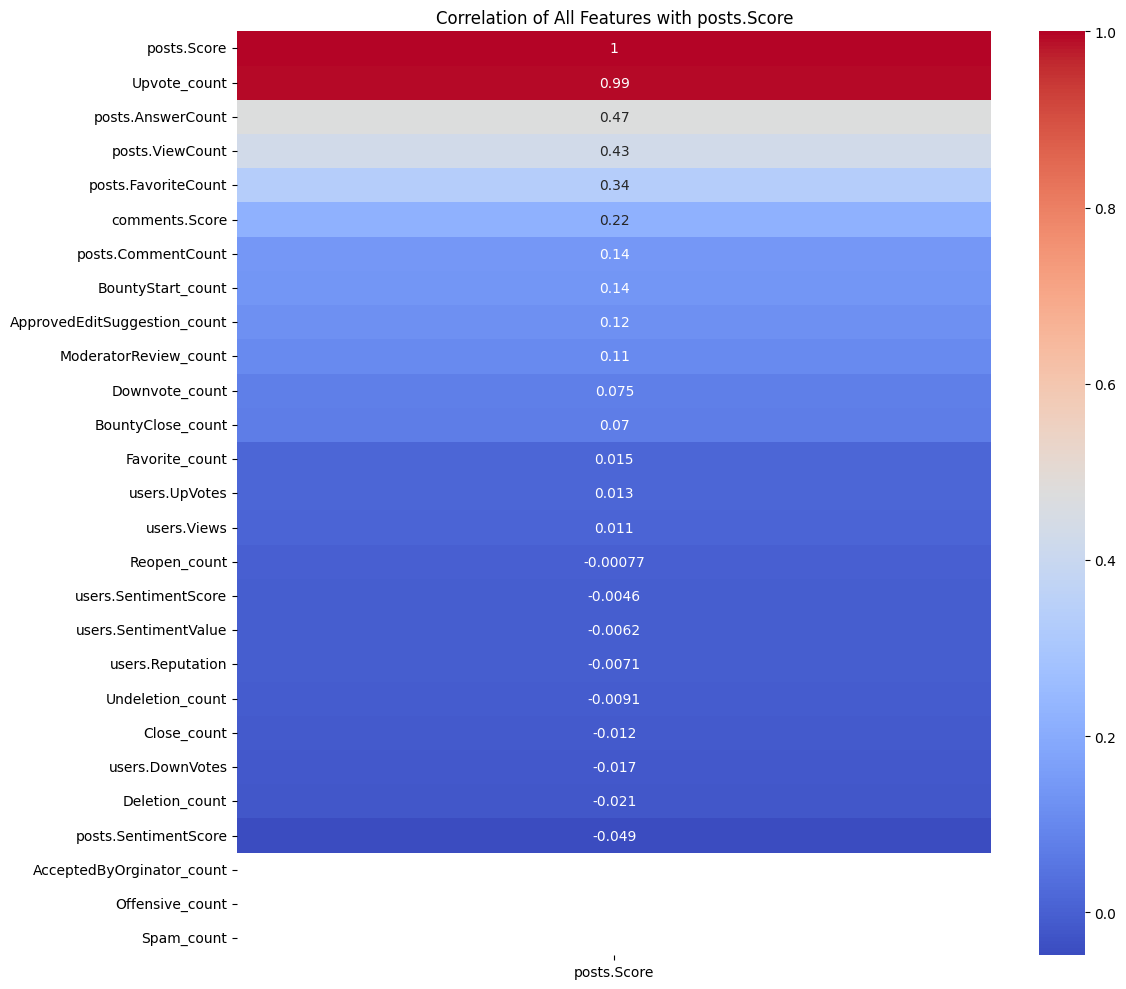

In [48]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_full[['posts.Score']].sort_values(by='posts.Score', ascending=False),
            annot=True, cmap='coolwarm')
plt.title("Correlation of All Features with posts.Score")
plt.tight_layout()
plt.show()


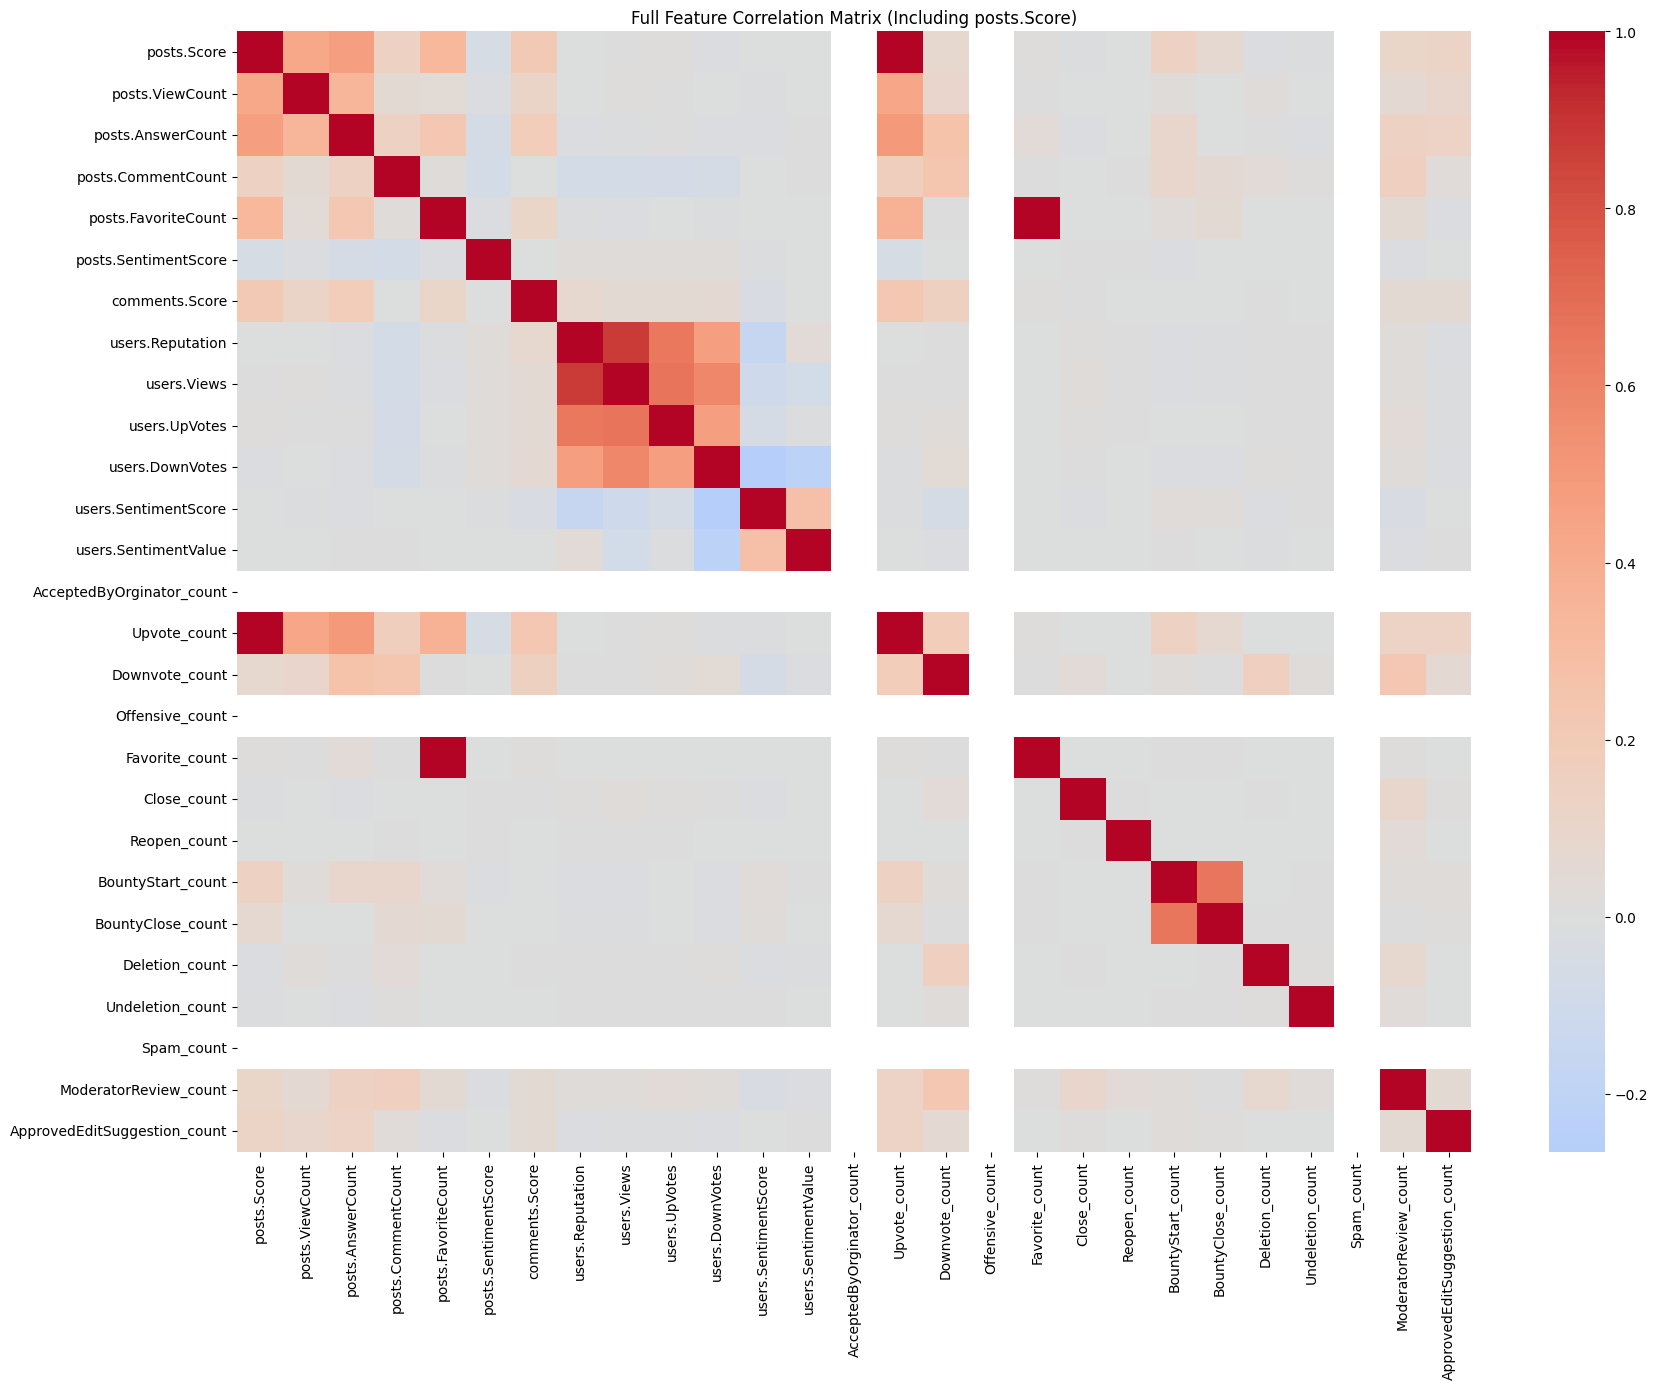

In [49]:
plt.figure(figsize=(18, 14))
sns.heatmap(corr_full, cmap='coolwarm', center=0, annot=False)
plt.title("Full Feature Correlation Matrix (Including posts.Score)")
plt.tight_layout()
plt.show()

In [50]:
num_cols = answers_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
filtered_num_cols = [col for col in num_cols if 'Id' not in col]

# 计算包含 posts.Score 的相关性矩阵
corr_full = questions_df[filtered_num_cols].corr()

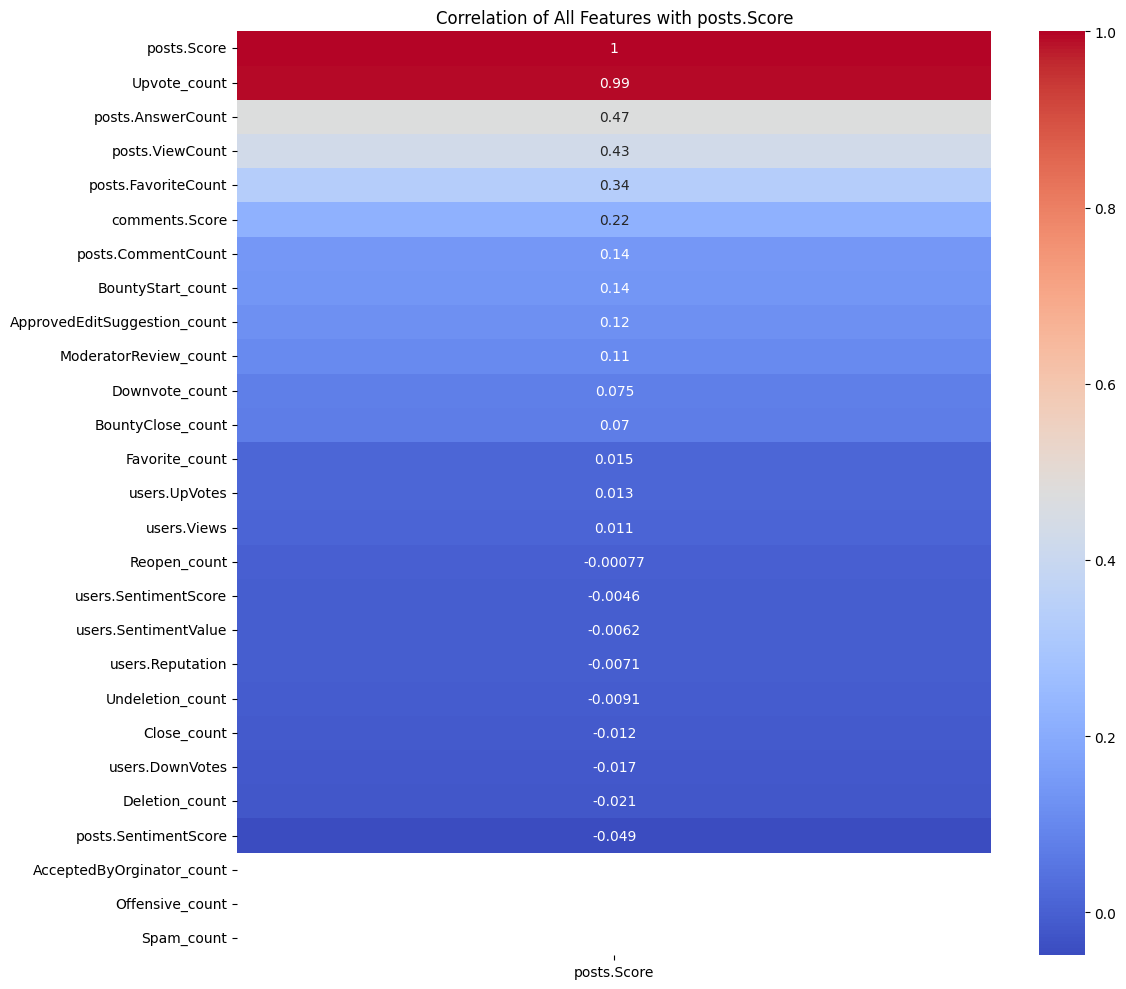

In [51]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_full[['posts.Score']].sort_values(by='posts.Score', ascending=False),
            annot=True, cmap='coolwarm')
plt.title("Correlation of All Features with posts.Score")
plt.tight_layout()
plt.show()

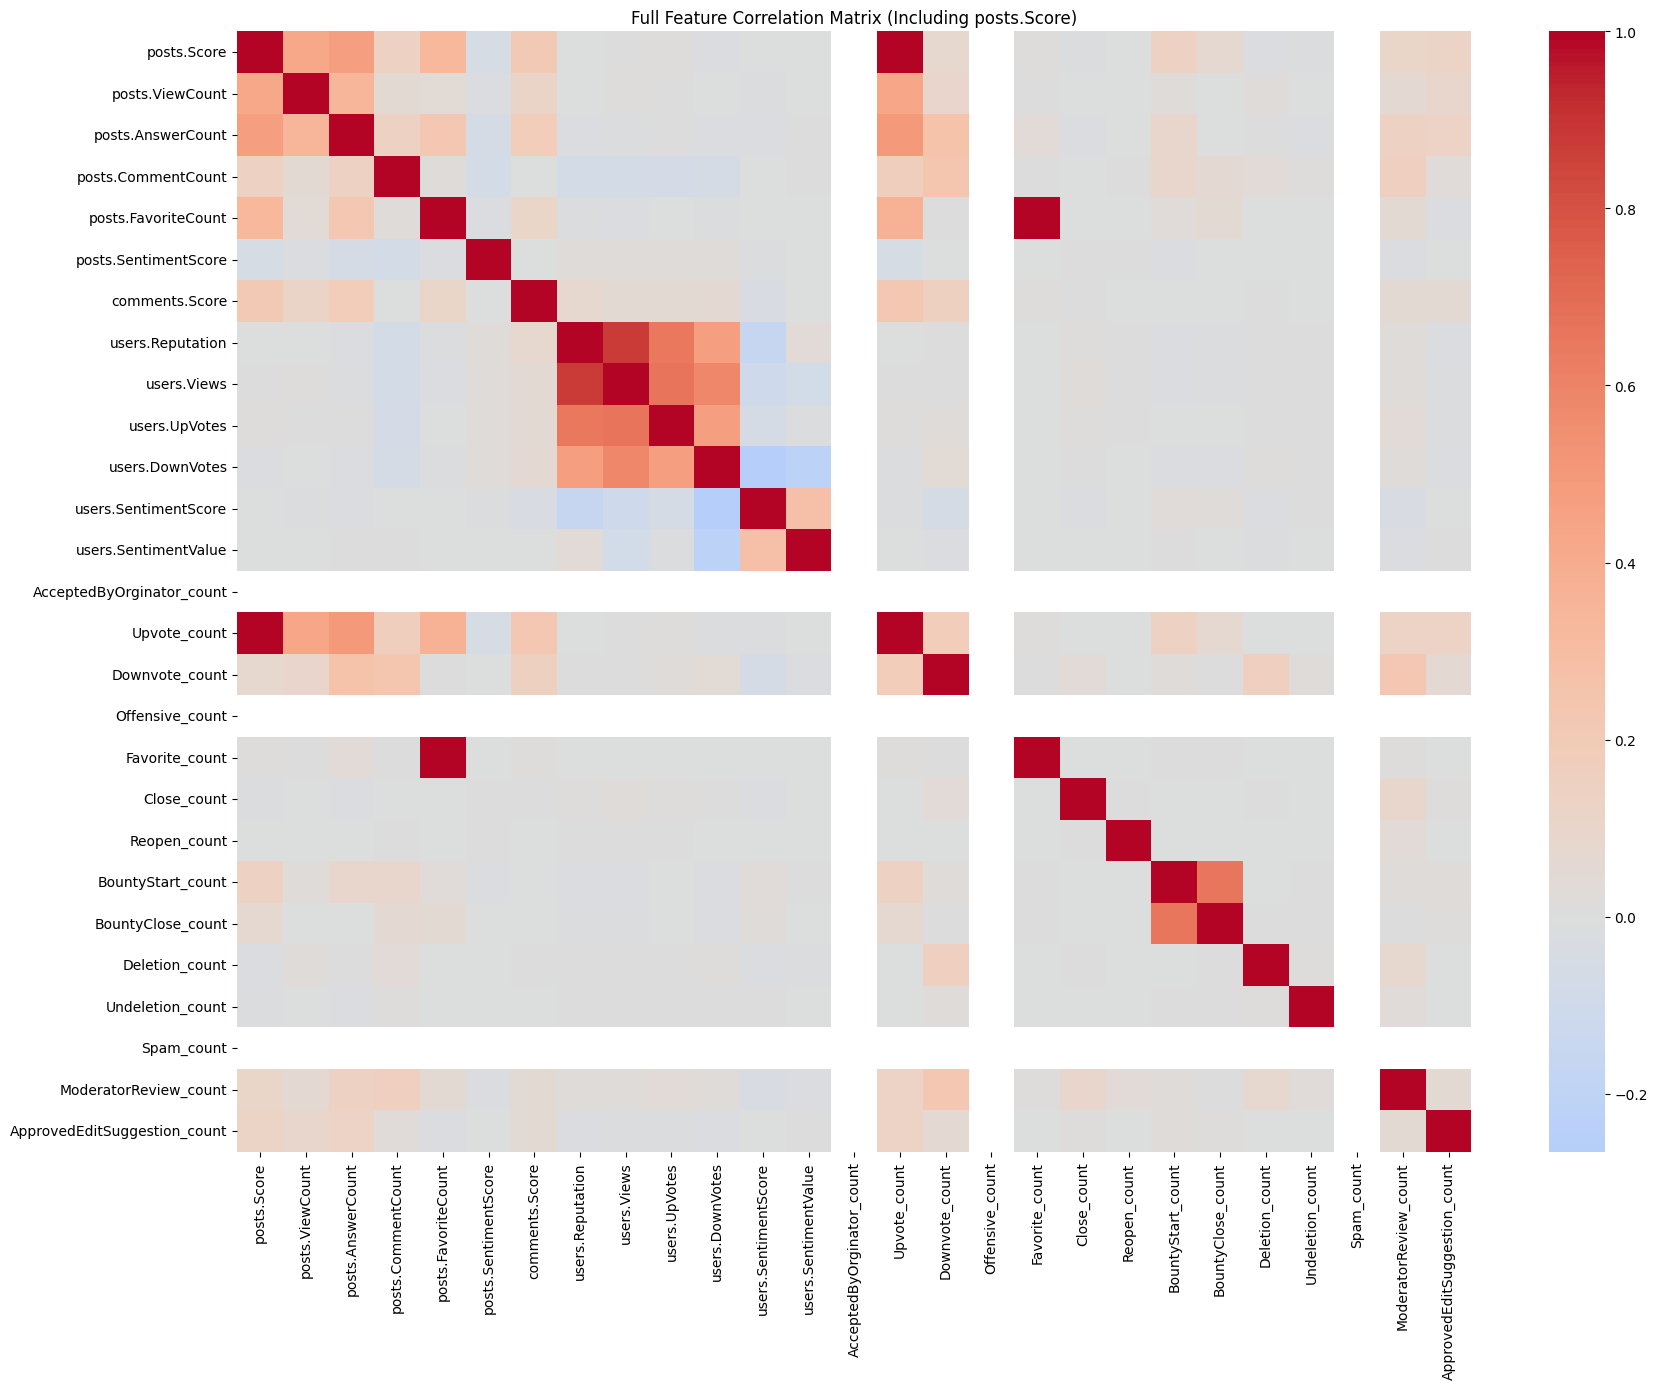

In [52]:
plt.figure(figsize=(18, 14))
sns.heatmap(corr_full, cmap='coolwarm', center=0, annot=False)
plt.title("Full Feature Correlation Matrix (Including posts.Score)")
plt.tight_layout()
plt.show()

In [38]:
df = pd.get_dummies(df, columns=['users.Country', 'users.SentimentLabel', 'posts.SentimentLabel'], drop_first=True)


In [39]:
df['TitleLength'] = df['posts.Title'].fillna('').apply(lambda x: len(x.split()))
df['CommentLength'] = df['comments.Text'].fillna('').apply(lambda x: len(x.split()))


In [40]:
df['HasCodeBlock'] = df['posts.Body'].fillna('').str.contains(r'<code>|```').astype(int)
df['NumLinks'] = df['posts.Body'].fillna('').str.count('http')


In [41]:
df

,PostId,posts.PostTypeId,posts.AcceptedAnswerId,posts.CreationDate,posts.Score,posts.ViewCount,posts.Body,posts.OwnerUserId,posts.LastEditorUserId,posts.LastEditDate,...,users.Country_zambia,users.Country_zimbabwe,users.SentimentLabel_neutral,users.SentimentLabel_positive,posts.SentimentLabel_neutral,posts.SentimentLabel_positive,TitleLength,CommentLength,HasCodeBlock,NumLinks
0,1,1,5.0,2010-11-02 18:59:01.140,87,20982.0,I often hear about subatomic particles having ...,7.0,520.0,2012-08-19 23:00:18.417,...,False,False,False,False,True,False,9,13,0,0
1,1,1,5.0,2010-11-02 18:59:01.140,87,20982.0,I often hear about subatomic particles having ...,7.0,520.0,2012-08-19 23:00:18.417,...,False,False,False,False,True,False,9,28,0,0
2,1,1,5.0,2010-11-02 18:59:01.140,87,20982.0,I often hear about subatomic particles having ...,7.0,520.0,2012-08-19 23:00:18.417,...,False,False,True,False,True,False,9,1,0,0
3,2,1,5704.0,2010-11-02 19:09:48.680,31,3946.0,How would you explain string theory to non-phy...,23.0,58382.0,2020-06-14 12:52:57.027,...,False,False,True,False,True,False,8,46,0,0
4,2,1,5704.0,2010-11-02 19:09:48.680,31,3946.0,How would you explain string theory to non-phy...,23.0,58382.0,2020-06-14 12:52:57.027,...,False,False,False,False,True,False,8,31,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339924,808520,1,808552.0,2024-03-31 23:05:36.567,1,66.0,For simplicity I will be considering $\phi^4$ ...,288281.0,2451.0,2024-04-01 01:26:51.400,...,False,False,True,False,False,False,10,22,0,0
1339925,808520,1,808552.0,2024-03-31 23:05:36.567,1,66.0,For simplicity I will be considering $\phi^4$ ...,288281.0,2451.0,2024-04-01 01:26:51.400,...,False,False,False,False,False,False,10,39,0,0
1339926,808520,1,808552.0,2024-03-31 23:05:36.567,1,66.0,For simplicity I will be considering $\phi^4$ ...,288281.0,2451.0,2024-04-01 01:26:51.400,...,False,False,True,False,False,False,10,28,0,0
1339927,808520,1,808552.0,2024-03-31 23:05:36.567,1,66.0,For simplicity I will be considering $\phi^4$ ...,288281.0,2451.0,2024-04-01 01:26:51.400,...,False,False,False,False,False,False,10,10,0,0
